In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import PIL

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_location = '/home/marcin/Datasets/udacity-challange-flower-data/flower_data/'

# Baseline with DataLoaders

Define transforms

In [4]:
imgnet_mean, imgnet_std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])

In [5]:
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.Pad(100, padding_mode='reflect'),
    transforms.RandomRotation(45),
    transforms.CenterCrop(256),
    transforms.RandomResizedCrop(224, scale=(0.8 , 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std)
])
# transforms_list = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(imgnet_mean, imgnet_std)
# ])

In [6]:
transforms_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

Test transforms

In [10]:
def tensor_img_2_numpy(tensor_img):
    ttt = transforms.functional.normalize(tensor_img, -imgnet_mean/imgnet_std, 1/imgnet_std)
    return transforms.functional.to_pil_image(ttt)

In [11]:
img = PIL.Image.open(os.path.join(dataset_location, 'train/1/image_06734.jpg'))

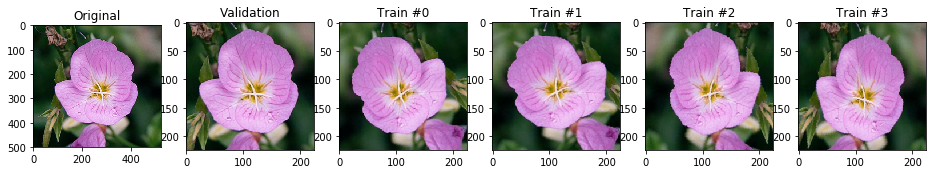

In [12]:
fig, axes = plt.subplots(ncols=6, figsize=[16,4])

axes[0].set_title('Original')
axes[0].imshow(img)

axes[1].set_title('Validation')
tensor_img = transforms_valid(img)
axes[1].imshow(tensor_img_2_numpy(tensor_img))

for i in range(2, len(axes)):
    axes[i].set_title(f'Train #{i-2}')
    tensor_img = transforms_train(img)
    axes[i].imshow(tensor_img_2_numpy(tensor_img))    

**Create Dataloaders**

In [13]:
dataset_train = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_train)
dataset_valid = datasets.ImageFolder(os.path.join(dataset_location, 'valid'), transforms_valid)
print('Number of train images:', len(dataset_train))
print('Number of valid images:', len(dataset_valid))

Number of train images: 6552
Number of valid images: 818


In [14]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True,
                                               num_workers=6, pin_memory=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=16, shuffle=True,
                                               num_workers=6, pin_memory=True)

# Create and Train Model

In [15]:
model = models.densenet121(pretrained=True)

# Freeze feature paremeters
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.classifier = classifier

model = model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [16]:
# model = models.resnet34(pretrained=True)

# # Freeze feature paremeters
# # for param in model.parameters():
# #     param.requires_grad = False

# # Replace classifier
# classifier = nn.Sequential(OrderedDict([
#     ('fc2', nn.Linear(512, 102)),
#     ('output', nn.LogSoftmax(dim=1))
# ]))
# model.fc = classifier

# model = model.to(device)

# criterion = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

Helper

In [17]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

Train model

In [18]:
num_epochs = 20
batch_size = 64

since = time.time()

hist = { 'tepoch':[], 'tloss':[], 'tacc':[],  # mini-batch loss/acc every iteration
         'vepoch':[], 'vloss':[], 'vacc':[],
         'train_loss':[], 'train_acc':[],     # train set loss/acc every epoch
         'valid_loss':[], 'valid_acc':[] }        # valid set loss/acc every epoch

for epoch in range(num_epochs):
    
    epoch_time_start = time.time()
    
    ### Train ###
    model.train()
    loss_sum = 0
    acc_sum = 0
    for images, labels in dataloader_train:
        
        # Push to GPU
        x = images.to(device)
        y = labels.to(device)
        
        # Optimize
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # Record per-iteration stats
        with torch.no_grad():
            acc = accuracy(outputs, y)
            loss_sum += loss.item() * len(images)
            acc_sum += acc.item() * len(images)
            hist['tepoch'].append( epoch )
            hist['tacc'].append( acc.item() )
            hist['tloss'].append( loss.item() )
            
    hist['train_loss'].append( loss_sum / len(dataset_train) )
    hist['train_acc'].append( acc_sum / len(dataset_train) )
    
    ### Evaluate ###
    model.eval()
    loss_sum = 0
    acc_sum = 0
    for images, labels in dataloader_valid:
        
        # Push to GPU
        x = images.to(device)
        y = labels.to(device)
        
        with torch.no_grad():
            outputs = model(x)
            loss = criterion(outputs, y)
            acc = accuracy(outputs, y)
            loss_sum += loss.item() * len(images)
            acc_sum += acc.item() * len(images)
            hist['vepoch'].append( epoch )
            hist['vloss'].append( loss.item() )
            hist['vacc'].append( acc.item() )
    
    hist['valid_loss'].append( loss_sum / len(dataset_valid) )
    hist['valid_acc'].append( acc_sum / len(dataset_valid) )
    
    epoch_time_interval = time.time() - epoch_time_start
    
    ### Print Summary ###
    if epoch == 0:
        print('      (time )   ep             loss / acc                loss / acc')
    print(f'Epoch ({epoch_time_interval:4.2f}s): {epoch:3}'
          f'    Train: {hist["train_loss"][-1]:6.4f} / {hist["train_acc"][-1]:6.4f}'
          f'    Valid: {hist["valid_loss"][-1]:6.4f} / {hist["valid_acc"][-1]:6.4f}')
        
            
print(time.time() - since)

      (time )   ep             loss / acc                loss / acc
Epoch (27.93s):   0    Train: 2.6767 / 0.3953    Valid: 1.0420 / 0.7653
Epoch (27.68s):   1    Train: 1.0179 / 0.7326    Valid: 0.6554 / 0.8252
Epoch (27.86s):   2    Train: 0.6894 / 0.8091    Valid: 0.5204 / 0.8582
Epoch (27.77s):   3    Train: 0.5668 / 0.8433    Valid: 0.3951 / 0.8912
Epoch (28.26s):   4    Train: 0.4904 / 0.8600    Valid: 0.3629 / 0.8900
Epoch (27.99s):   5    Train: 0.4457 / 0.8707    Valid: 0.3281 / 0.9108
Epoch (27.85s):   6    Train: 0.4082 / 0.8822    Valid: 0.3176 / 0.9205
Epoch (27.84s):   7    Train: 0.3672 / 0.8901    Valid: 0.3383 / 0.9046
Epoch (27.73s):   8    Train: 0.3733 / 0.8858    Valid: 0.2911 / 0.9218
Epoch (27.84s):   9    Train: 0.3444 / 0.8958    Valid: 0.2522 / 0.9377
Epoch (27.75s):  10    Train: 0.3338 / 0.8973    Valid: 0.2886 / 0.9193
Epoch (27.86s):  11    Train: 0.3083 / 0.9093    Valid: 0.2674 / 0.9340
Epoch (27.80s):  12    Train: 0.3161 / 0.9029    Valid: 0.3174 / 0.9

In [19]:
def pretty_plot(ax, data, label, color, alpha=1.0):
    def smooth(y, n):
        return np.convolve(y, v=np.ones(n)/n, mode='same')
    ax.scatter(range(len(data)), data, marker='.', s=2, color=color)
    ax.plot(smooth(data, 20), label=label, color=color)

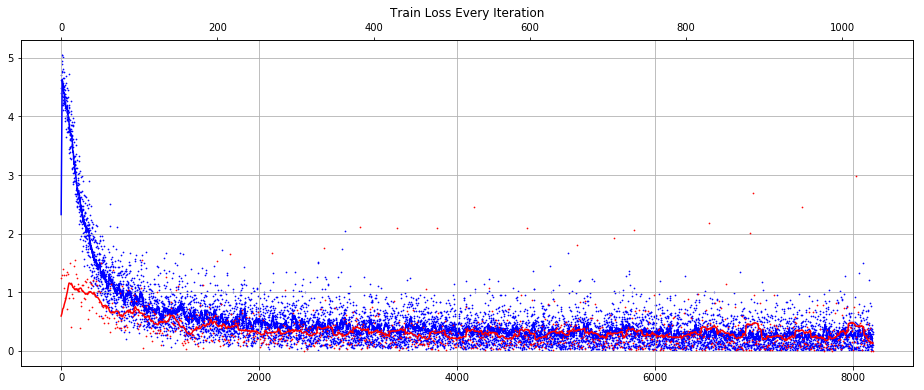

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,6])
pretty_plot(ax, hist['tloss'], 'tloss', 'blue')
pretty_plot(ax.twiny(), hist['vloss'], 'vloss', 'red')
ax.set_title('Train Loss Every Iteration');
ax.grid();

In [21]:
def plot_hist(hist, title):
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,3])
     
    fig.suptitle(title, fontsize=16)
    
    #ax.plot(hist['train_loss'], label='train_loss', color='blue')
    pretty_plot(ax.twiny(), hist['tloss'], 'tloss', color='blue', alpha=.5)
    ax.plot(hist['valid_loss'], label='valid_loss', color='orange')
    ax.set_title('Loss'); ax.legend(); ax.grid(); ax.set_ylim([0, 1]);
    
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,3])
    ax2.plot(hist['train_acc'], label='train_acc', color='blue')
    #pretty_plot(ax2.twiny(), hist['tacc'], 'tacc', color='blue', alpha=1)
    ax2.plot(hist['valid_acc'], label='valid_acc', color='orange')
    ax2.set_title('Accuracy'); ax2.legend(); ax2.grid(); ax2.set_ylim([.8, 1]);
    
    plt.tight_layout()

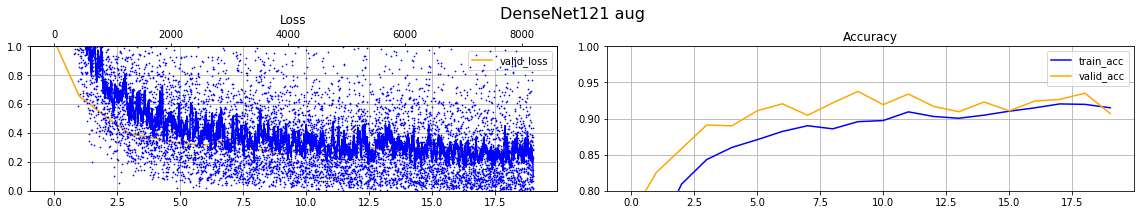

In [22]:
plot_hist(hist, title='DenseNet121 aug')

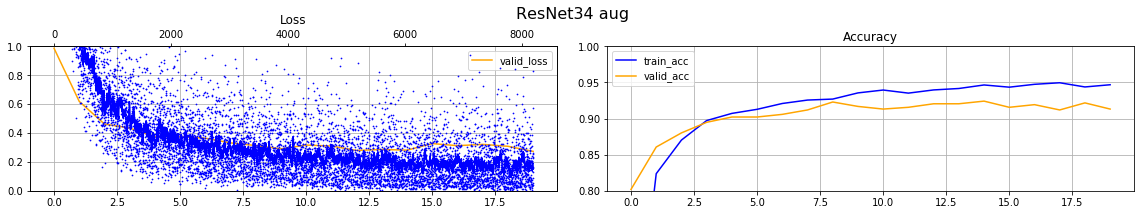

In [15]:
plot_hist(hist, title='ResNet34 aug')

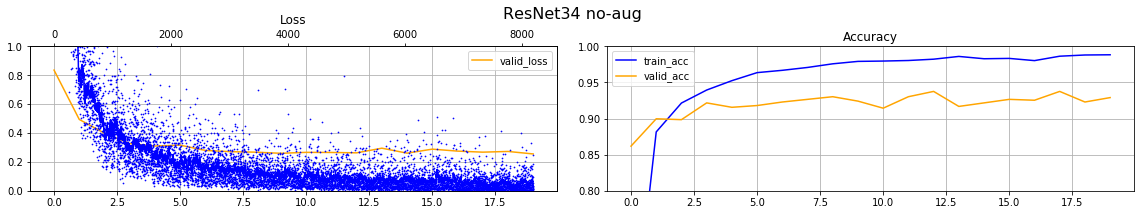

In [77]:
plot_hist(hist, title='ResNet34 no-aug')